# From MARC to LOD: Mining and Publishing Linked Open Bibliographic Data with Python 

Machine Readable Cataloging (MARC) is a widely used standard for the representation and exchange of bibliographic and related information in machine-readable form. (https://www.loc.gov/marc/bibliographic/concise/bdintro.html) Developed by Henriette Avram at the Library of Congress between the 1965 and the 1968, MARC provided a framework for organizing bibliographic data (such as physical description, publication information, notes, and so on) and facilitating the management and retrieval of various bibliographic materials, ranging from textual objects to geographic maps, music, and even software. By the half of the next decade, MARC formats were everywhere and became the _de facto_ standard for structuring and publishing bibliographic data. (Avram, H. D. (1975). MARC; its History and Implications. https://files.eric.ed.gov/fulltext/ED127954.pdf)

The MARC standards define three aspects of a MARC record: the field designations within each record, the structure of the record, and the actual content of the record itself.

Specific information about the item being described can be communicated through field labels in a MARC record. These labels can include things like the author, title, publication information, and more. Each field in a record is identified with a straightforward three-digit numeric code that runs from 001 to 999. For example, field 100 designates the work's principal author, field 245 the title, and field 260 the publication information. Eventual subfields are designated using single letters or numeric labels. Field 260, for instance, has several subfields, like "a" for the publication location, "b" for the publisher, and "c" for the publication date.

MARC records are frequently concatenated into a single file and are normally stored and sent as binary files. Every data set has a framework that describes how the elements are arranged and conforms to ISO 2709 standards. This structure consists of an initial set of characters that serve as a directory for finding fields and subfields within the record, as well as a marker that indicates the start and finish of each record. An important note that will be useful later: MARC records can now be represented in XML format thanks to the MARCXML schema, developed as an alternative structure in which the fields themselves are represented using XML markup while staying conceptually the same.

MARC records information about a bibliographic item by emphasizing its metadata over its actual content. As such, it serves as a metadata transfer standard as opposed to a content standard. Only the contents of a few fixed fields are specified by the MARC standards themselves; thus, the specific data entered into each MARC field are usually determined by external standards, such as RDA for physical descriptions and LCSH for subject terms.

While MARC21 has been a cornerstone of library cataloging for decades, it also comes with several notable issues and challenges:

* Complexity: MARC21 is known for its complexity, which can make it difficult for catalogers to learn and use effectively. The intricacies of MARC coding and the wide range of fields and subfields can lead to errors and inconsistencies in cataloging practices.
* Limited Data Structure: MARC21's structure was designed in an era when physical cards were used for cataloging, leading to limitations in representing modern digital resources and complex metadata. It may not fully accommodate the needs of digital collections, multimedia resources, or non-traditional materials.
* Data Redundancy: MARC records often contain redundant information, with data repeated across multiple fields and subfields. This redundancy can increase the size of records and make them less efficient for storage and retrieval.
* Interoperability Challenges: While MARC21 is widely used, its complexity and variations between implementations can create challenges for interoperability between library systems and consortia. Different interpretations of MARC standards by different institutions can lead to inconsistencies in data exchange.
* Limited Support for Linked Data: MARC21 was developed before the concept of linked data gained prominence. As a result, it lacks native support for linked data principles and semantic web technologies, making it challenging to integrate MARC records into linked data environments.
* Maintenance and Evolution: The maintenance and evolution of MARC standards require coordinated efforts from the library community and standardization bodies. Updates to MARC21 can be slow, and the standard may struggle to keep pace with evolving technologies and user needs.

Despite these challenges, MARC21 continues to be widely used in library environments due to its established infrastructure and compatibility with existing systems. However, there is ongoing discussion within the library community about the need for alternative metadata standards and approaches that better align with modern library practices and emerging technologies.

In this tutorial, we will explore a possible way to transition from MARC records to Linked Open Data using Python. We will use the [dardwinslibrary](https://archive.org/details/darwinslibrary) collection, a scholarly edition of Darwin's scientific archive, as an exemplary case study. In particular, we will go through each stage of the process and address its complexities, from extracting bibliographic records from the Internet Archive to leveraging Python for data cleansing and preparation, ultimately facilitating their conversion into Linked Open Data. Whether you are an experienced data professional or new to Python programming, this tutorial is designed to provide a comprehensive understanding of bibliographic data manipulation.

## Step 01: Import needed libraries

In the initial step of our data conversion process, we begin by importing essential Python libraries for carrying out the process:
* `os`: This library provides a platform-independent interface for interacting with the operating system, facilitating tasks such as file and directory operations.
* `re`: Regular expressions are a powerful tool for pattern matching and string manipulation. The 're' library empowers us to efficiently navigate and extract relevant information from our MARC records.
* `pymarc`: Central to our mission, the 'pymarc' library allows us to work with MARC data effortlessly. Its functionality enables parsing, editing, and processing MARC records, essential for our data mining endeavors.
* `internetarchive` (`ia`): Leveraging the 'internetarchive' library grants us seamless access to the Internet Archive, a rich repository of bibliographic records. This connection is fundamental for retrieving the data from the specified collection.
* `pandas` (`pd`): As a robust data manipulation and analysis library, 'pandas' is indispensable for organizing, cleaning, and transforming our data.
* `missingno` (`msgno`): Data quality is paramount, and 'missingno' aids us in visualizing missing data patterns within our dataset.

In [1]:
import os, re, pymarc
import internetarchive as ia
import pandas as pd
import missingno as msgno
%matplotlib inline

## Step 02: Data selection

In this initial step, we kick off the process of gathering bibliographic records from the `darwinslibrary` collection on the Internet Archive. The Python code below does the job.

In [2]:
# Define the name of the collection on Internet Archive
collection_name = "darwinslibrary"

# Define the path where the files will be saved
save_path = "marc-files"

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.mkdir(save_path)

# Search for items in the collection
items = ia.search_items(f'collection:{collection_name}')

The variable `collection_name` is set to "darwinslibrary," pointing to the specific collection we are interested in on the Internet Archive. The variable `save_path` determines where the collected MARC files will be stored. If the chosen directory doesn't exist, the code makes it on the fly, keeping things neat and organized. We also make sure the storage directory exists; if not, the code creates a new one named "marc-files." This ensures a smooth process by providing a clear place for our collected data. Finally, by using the `internetarchive` library, the code searches for items in the specified collection.

## Step 03: Download the collection

Now, let's get the nitty-gritty, and snag those MARCXML records for each item in our collection. Here is the Python code.

In [3]:
# For each item, download the MARCXML record
for item in items:

    # Get the item identifier
    identifier = item["identifier"]
    
    # Try to download the record with that identifier, in MARC format, at the `save_path` destination, and do not create a new folder for each file
    try:
        xml_files = ia.download(identifier, 
                                formats=["MARC"], 
                                verbose=True, 
                                destdir=save_path,
                                no_directory=True)

    # If there is a error, print it
    except Exception as e:
        print(e)

Abercrombie1838wa66W:
 skipping marc-files\Abercrombie1838wa66W_marc.xml, file already exists based on length and date.
Abercrombie1838wa66W_MS:
 skipping marc-files\Abercrombie1838wa66W_MS_marc.xml, file already exists based on length and date.
Agassiz1850up52I:
 skipping marc-files\Agassiz1850up52I_marc.xml, file already exists based on length and date.
Agassiz1850up52I_MS:
 skipping marc-files\Agassiz1850up52I_MS_marc.xml, file already exists based on length and date.
Agassiz2006ft69Y:
 skipping marc-files\Agassiz2006ft69Y_marc.xml, file already exists based on length and date.
Agassiz2006ft69Y_MS:
 skipping marc-files\Agassiz2006ft69Y_MS_marc.xml, file already exists based on length and date.
Barker-Webb1840yf41S:
 skipping marc-files\Barker-Webb1840yf41S_marc.xml, file already exists based on length and date.
Barker-Webb1840yf41S_MS:
 skipping marc-files\Barker-Webb1840yf41S_MS_marc.xml, file already exists based on length and date.
Bechstein1840ob74D:
 skipping marc-files\Bechste

First, we systematically navigate through each item by referencing its unique identifier. Then, we employ the `internetarchive` library to fetch MARCXML records for each item. These records are then stored in the specified directory denoted by `save_path`. The `verbose=True` ensures the system returns a clear view of each execution of the processes. Lastly, we place a error handling mechanism to address any unforeseen issues that may arise during the download process.

## Step 04: Get the data

In this stage, our focus shifts to extracting essential metadata from the previously acquired MARCXML records. Our objective is to mine pertinent information such as author, title, notes, supplemental material details, and publication specifics.

We start by defining a list in which we will store each record's data.

In [4]:
# Prepare the list of dictionaries
data = []

Then, we define a series of functions, each dedicated in capturing a specific facet of information regarding a record (e.g. its identifier, author, title, etc.). Luckily enough, the input files are written in an XML-based schema that follows MARC structures and terminology, and thus information is already organized in terms of structure and semantics.

In [5]:
def get_author(record):
    '''
    Get the "author" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        author (str): a string containing the name of the author extracted from the MARCXML file.
    '''
    try:
        author = record['100']['a']
        return author
    except Exception as e:
        print(e)

In [6]:
def get_title(record):
    '''
    Get the "title" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        title (str): a string containing the title of the record extracted from the MARCXML file.
    '''
    try:
        title = record['245']['a']
        return title
    except Exception as e:
        print(e)

In [7]:
def get_subtitle(record):
    '''
    Get the "subtitle" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        subtitle (str): a string containing the subtitle of the record extracted from the MARCXML file.
    '''
    try:
        subtitle = record['245']['b']
        return subtitle
    except Exception as e:
        print(e)

In [8]:
def get_pub_place(record):
    '''
    Get the "publication place" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        pub_place (str): a string containing the name of the publication place extracted from the MARCXML file.
    '''
    try:
        pub_place = record['260']['a']
        return pub_place
    except Exception as e:
        print(e)

In [9]:
def get_publisher(record):
    '''
    Get the "publisher" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        publisher (str): a string containing the name of the publisher extracted from the MARCXML file.
    '''
    try:
        publisher = record['260']['b']
        return publisher
    except Exception as e:
        print(e)

In [10]:
def get_pub_date(record):
    '''
    Get the "publication date" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        pub_date (str): a string containing the publication date extracted from the MARCXML file.
    '''
    try:
        pub_date = record['260']['c']
        return pub_date
    except Exception as e:
        print(e)

In [11]:
def get_note(record):
    '''
    Get the "note" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        notes (list): a list of strings containing notes extracted from the MARCXML file.
    '''
    try:
        notes = [note['a'] for note in record.get_fields('500')]
        return notes
    except Exception as e:
        print(e)

In [12]:
def get_ident(lst):
    '''
    Get the "identifier" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        ident (str): a string containing the identifier extracted from the MARCXML file.
    '''
    try:
        for strng in lst:
            if strng.startswith('Identifier'):
                ident = strng[12:]
                return ident
    except Exception as e:
        print(e)

In [13]:
def get_alt_ident(lst):
    '''
    Get alternative identifier metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        ident (str): a string containing an alternative identifier extracted from the MARCXML file.
    '''
    try:
        for strng in lst:
            if strng.startswith('Public number: '):
                ident = strng[15:]
                return ident
    except Exception as e:
        print(e)

In [14]:
def get_supp_material(record):
    '''
    Get the "supplement special issue entry" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        supp_material (str): a string containing the identifier of the supplement special issue entry extracted from the MARCXML file.
    '''
    try:
        supp_material = record['770']['o']
        return supp_material
    except Exception as e:
        print(e)

In [15]:
def get_supp_parent(record):
    '''
    Get the "supplement parent entry" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        supp_parent (str): a string containing the identifier of the supplement parent entry extracted from the MARCXML file.
    '''
    try:
        supp_parent = record['772']['o']
        return supp_parent
    except Exception as e:
        print(e)

For each record, a dictionary is created, encapsulating the metadata attributes we are going to extract. These include:
- `ID`: the identifier of the record;
- `ALT_ID`: an alternative identifier, extracted from the free text in the `note` field;
- `AUTHOR`: the author's full name;
- `TITLE`: the title of the bibliographic work;
- `SUBTITLE`: the subtitle of the bibliographic work;
- `NOTE`: any textual note about the bibliographic work;
- `SUPP_MATERIAL`: the identifier of supplemental material, if any;
- `SUPP_PARENT`: the identifier of the parent record of supplementary material, if any;
- `PUB_PLACE`: the name of the place of publication;
- `PUBLISHER`: the name of the publisher;
- `PUB_DATE`: the full publication date.

The structured dictionaries are systematically appended to the `data` list, creating a comprehensive repository of bibliographic metadata.

In [16]:
# Iterate over the folder
for filename in os.listdir(save_path):

    # Construct the path to the MARCXML file in the current folder
    file_path = os.path.join(save_path, filename)

    # Check if the file exists at that path
    if os.path.isfile(file_path):
        
        # Open the MARCXML file and return the records within it as an array
        with open(file_path, 'rb') as marc_file:
            records = pymarc.marcxml.parse_xml_to_array(marc_file)
    
            # Iterate over the MARC records array and generate a dictionary for each record
            for record in records:
                dct = {
                    'ID': get_ident(get_note(record)),
                    'ALT_ID': get_alt_ident(get_note(record)),
                    'AUTHOR': get_author(record),
                    'TITLE': get_title(record),
                    'SUBTITLE': get_subtitle(record),
                    'NOTE': ' '.join(get_note(record)),
                    'SUPP_MATERIAL': get_supp_material(record),
                    'SUPP_PARENT': get_supp_parent(record),
                    'PUB_PLACE': get_pub_place(record),
                    'PUBLISHER': get_publisher(record),
                    'PUB_DATE': get_pub_date(record)
                }
                data.append(dct)

In order to make the functions work, we need to use `pymarc.marcxml.parse_xml_to_array`, a function from the `pymarc` library that allows parsing an XML file to return the records as an array. Then, each function is called on each record to populate the dictionary structure that in turn is added to the `data` list.

## Step 05: Data summarization
The main reason to organize our data into a list of dictionaries is to convert it into a DataFrame.

A Pandas DataFrame is a two-dimensional, labeled data structure provided by the `pandas` library. It consists of rows and columns, similar to a table or spreadsheet, where each column can have a different data type (e.g., integers, floats, strings) and is labeled with a unique name. DataFrames are versatile data structures commonly used for data manipulation, analysis, and exploration in data science and machine learning tasks. They offer powerful methods and functions for data indexing, slicing, filtering, grouping, joining, and more, making them a popular choice for working with structured data in Python.

In [17]:
# Create a DataFrame out of the list of dictionaries
df = pd.DataFrame(data)

And here it is! Now that we have organized our data into a DataFrame, we can use a series of utility functionalities to gain a better understanding of it. For example, to have a quick look at the data inside our DataFrame, we can use the `.head()` function to return the first five rows.

In [18]:
# Use .head() and print the first five rows
print(df.head())

                         ID ALT_ID              AUTHOR  \
0     Abercrombie1838wa66W.  0001.  Abercrombie, John.   
1  Abercrombie1838wa66W_MS.   None    Darwin, Charles.   
2         Agassiz1850up52I.  0017.     Agassiz, Louis.   
3      Agassiz1850up52I_MS.   None    Darwin, Charles.   
4         Agassiz2006ft69Y.  0015.     Agassiz, Louis.   

                                               TITLE  \
0  Inquiries concerning the intellectual powers a...   
1  Inquiries concerning the intellectual powers a...   
2  Lake Superior: its character, vegetation, and ...   
3  Lake Superior: its character, vegetation, and ...   
4  Contributions to the natural history of the Un...   

                                            SUBTITLE  \
0                                               None   
1  [Supplementary material in Charles Darwin's co...   
2                                               None   
3  [Supplementary material in Charles Darwin's co...   
4                                 

WE WILL IMMEDIATELY SAVE THIS DATASET 
df.to_csv('2024-01-16_darwinslibrary_v001.csv', index=False)

Nice! We can already notice some interesting quirks in the data. For example:
- identifiers, names and notes seem to follow consistent patterns in their representation (such as `Surname, Name` for `AUTHOR` values);
- `ID` values contain both uppercase and lowercase characters, and end with a dot;
- `ALT_ID` values end with a dot;
- `AUTHOR` values often end with a dot or a comma;
- `SUPP_MATERIAL` and `SUPP_PARENT` contain both uppercase and lowercase characters, and are complementary with each other (the non-null values in one column can fill the null cells in the other column, and vice versa);
- `PUB_PLACE` and `PUBLISHER` values often end with a combination of punctuation and whitespace, and sometimes their null values are expressed through the string "[s.n.]";
- `PUB_DATE` values often end with a dot, sometimes they might be enclosed in square parentheses, sometimes they might actually represent a period of time (e.g. two dates connected with an hyphen), and their null values are expressed through the string "n.d."

We are still not done exploring, though. We can use the DataFrame's `.shape` method and the `.info()` and `.describe()` functions to visualize the Dataframe's dimensionality (number of rows and columns), general information, and descriptive statistics.

In [19]:
df.shape

(315, 11)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             264 non-null    object
 1   ALT_ID         140 non-null    object
 2   AUTHOR         312 non-null    object
 3   TITLE          315 non-null    object
 4   SUBTITLE       148 non-null    object
 5   NOTE           315 non-null    object
 6   SUPP_MATERIAL  132 non-null    object
 7   SUPP_PARENT    124 non-null    object
 8   PUB_PLACE      191 non-null    object
 9   PUBLISHER      183 non-null    object
 10  PUB_DATE       191 non-null    object
dtypes: object(11)
memory usage: 27.2+ KB


In [21]:
df.describe()

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,SUPP_MATERIAL,SUPP_PARENT,PUB_PLACE,PUBLISHER,PUB_DATE
count,264,140,312,315,148,315,132,124,191,183,191
unique,230,122,133,270,18,240,114,108,34,116,98
top,Kirby2006fz26R.,0843.,"Darwin, Charles.","Ornithological biography, or an account of the...",[Supplementary material in Charles Darwin's co...,,Lyell1837jf09J_MS,Kirby2006fz26R,London :,"John Murray,",1865.
freq,4,4,124,5,124,37,4,4,68,11,8


Splendid. Now we are aware of some other important aspects of our data. For example, considering the number of rows (_and thus values per column_) is 315, we can notice how some values are missing: as a matter of fact, only `TITLE` and `NOTE` are completely populated. Moreover, now we also know that `ID` values are not unique. To be more precise: 34 identifiers (264-230) are _not_ unique. Moreover, we also get some interesting tidbits about the most frequent values within the dataset: `Kirby2006fz26R.` (`ID`, 4 times); `Lyell1837jf09J_MS` (`SUPP_MATERIAL`, 4 times); `London` (`PUB_PLACE`, 68 times); `John Murray` (`PUBLISHER`, 11 times); and so on. Of course, these are the values _before_ data cleaning, so this information could still be subject to change.

## Step 06: Data cleaning
This takes us to the next phase: cleaning our dataset squeaky clean! Or, at least, try to. Data cleaning is a crucial step in the data analysis process, involving the identification, correction, and removal of inaccuracies, inconsistencies, and errors in datasets. This process ensures that the data is accurate, complete, and reliable for further analysis. Common data cleaning tasks include handling missing values, correcting data entry errors, standardizing formats, removing duplicate records, and dealing with outliers. In our case, cleaning our data means dealing with all the abnormalities we highlighted above. We will use more Python functions to deal with those by running them for each dictionary in `data`. 

First, we will define the necessary function to eliminate trailing those pesky punctuation and whitespaces.

In [22]:

def clean_trailing_punctuation(value):
    '''
    Clean trailing punctuation from each value in a DataFrame.

    Args:
        value (str): a string value contained in a DataFrame cell.

    Returns:
        value (str): a string containing the value cleaned from any existing trailing punctuation.
    '''
    try:
        value = re.sub(r'[.,!?:;\s]+$', '', value)
    except:
        None
    return value

Also, let us create another function deal with existing values that are used in a non-standard manner, like those "[s.n.]" and "n.d." strings.

In [23]:
def normalize_missing_value(value):
    '''
    Normalizes a missing value in a DataFrame into a None value.

    Args:
        value (str): a string value contained in a DataFrame cell.

    Returns:
        value (str): a string containing a None value if the input value contains "[s.n.]" or "n.d.".
    '''
    try:
        value = re.sub(r'\[s.n.\]|n.d.', 'None', value)
    except:
        None
    return value

Now, we start by creating a new empty list for the cleaned data.

In [24]:
clean_data = []

Then, we can iterate over the `data` array containing all our dictionaries in order to apply the cleaning functions we just defined to each dictionary. After that, we append each cleaned dictionary to the new `clean _data` list.

In [25]:
for dct in data:
    clean_dct = {key: normalize_missing_value(value) for key, value in dct.items()}
    clean_dct = {key: clean_trailing_punctuation(value) for key, value in clean_dct.items()}
    clean_data.append(clean_dct)

In [26]:
print(clean_data)

[{'ID': 'Abercrombie1838wa66W', 'ALT_ID': '0001', 'AUTHOR': 'Abercrombie, John', 'TITLE': 'Inquiries concerning the intellectual powers and the investigation of truth', 'SUBTITLE': None, 'NOTE': 'Location: Cambridge. Identifier: Abercrombie1838wa66W. Public number: 0001', 'SUPP_MATERIAL': 'Abercrombie1838wa66W_MS', 'SUPP_PARENT': None, 'PUB_PLACE': 'London', 'PUBLISHER': 'John Murray', 'PUB_DATE': '1838'}, {'ID': 'Abercrombie1838wa66W_MS', 'ALT_ID': None, 'AUTHOR': 'Darwin, Charles', 'TITLE': 'Inquiries concerning the intellectual powers and the investigation of truth', 'SUBTITLE': "[Supplementary material in Charles Darwin's copy]", 'NOTE': 'Identifier: Abercrombie1838wa66W_MS', 'SUPP_MATERIAL': None, 'SUPP_PARENT': 'Abercrombie1838wa66W', 'PUB_PLACE': None, 'PUBLISHER': None, 'PUB_DATE': None}, {'ID': 'Agassiz1850up52I', 'ALT_ID': '0017', 'AUTHOR': 'Agassiz, Louis', 'TITLE': 'Lake Superior: its character, vegetation, and animals, compared with those of other similar regions', 'SUBTIT

In [27]:
#df['RELATED'] = df['SUPP_MATERIAL'].fillna(df['SUPP_PARENT'])
#print(df.head())

In [28]:
#df = df.drop(columns=['SUPP_MATERIAL', 'SUPP_PARENT'])
#print(df.head())

### Missing data
Use `missingno` to quickly visualize missing data

<Axes: >

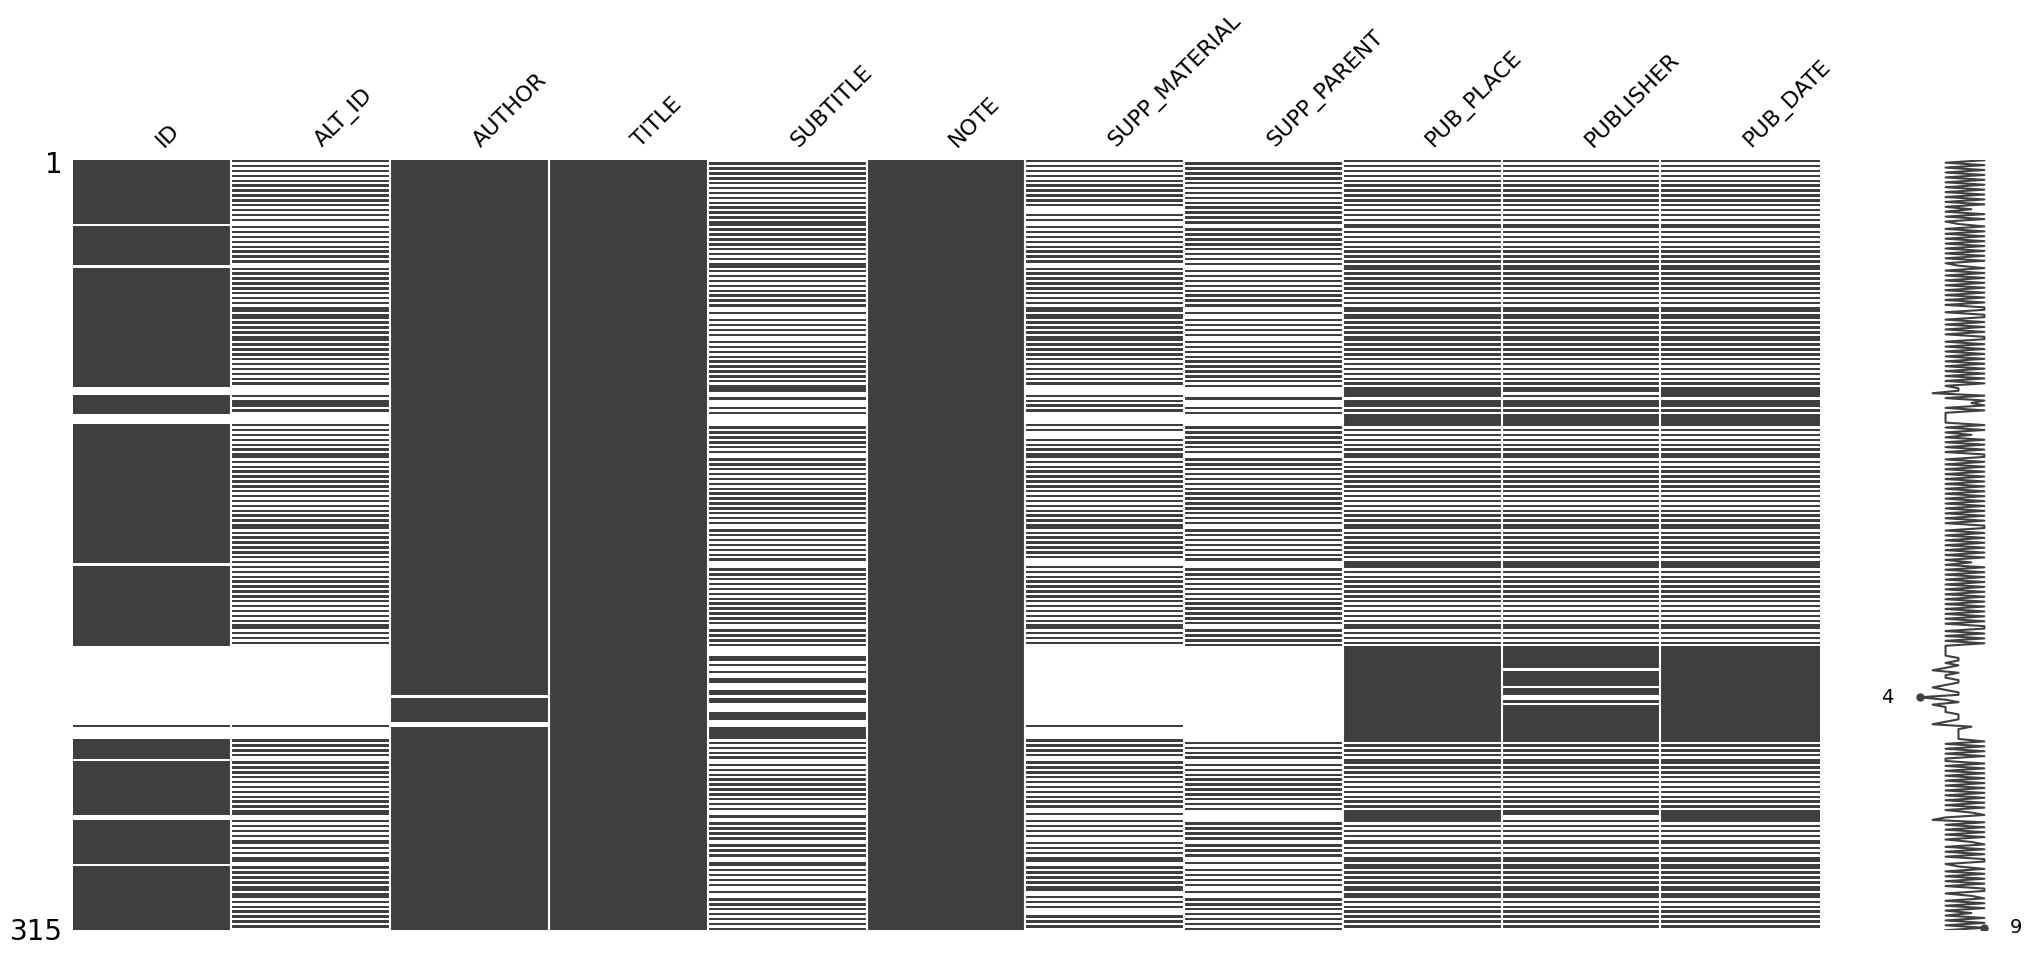

In [29]:
msgno.matrix(df)

There is a gap (nothing dramatic, but still), especially in those columns populated with identifiers

This can be a problem, since identifiers are the main reference mechanism we will use to generate a URI for each record

Let us see in detail those records that are missing their identifiers, among other information

In [30]:
df[df['ID'].isna()]

,ID,ALT_ID,AUTHOR,TITLE,SUBTITLE,NOTE,SUPP_MATERIAL,SUPP_PARENT,PUB_PLACE,PUBLISHER,PUB_DATE
26,None,None,"Berkenhout, John,",Clavis Anglíca linguæ botanicæ :,"or, a Botanical Lexicon in which the terms of ...",,None,None,"London,","Becket, de Houdt, Hawes, Clark & and Collins",1764.
43,None,None,"Cleland, John,","Evolution, expression, and sensation, cell lif...",y John Cleland,Publisher's advertisements: 16 p. at end.,None,None,"Glasgow,","James Maclehose,",1881
93,None,None,"Murphy, Joseph John",Habit and intelligence in their connexion with...,a series of scientific essays.,Published in two volumes.,None,None,London :,"Macmillan,",1869
94,None,None,"Murphy, Joseph John",Habit and intelligence in their connexion with...,a series of scientific essays.,Published in two volumes.,None,None,London :,"Macmillan,",1869
95,None,None,"Henle, Jacob,",Handbuch der systematischen Anatomie des Mensc...,None,,None,None,"Braunschweig,",None,1855-71.
104,None,None,"Vaucher, Jean Pierre Etienne.","Histoire physiologique des Plantes d'Europe, o...",None,,None,None,"Paris,",Aurel Freres;,1841.
105,None,None,"Vaucher, Jean Pierre Etienne.","Histoire physiologique des Plantes d'Europe, o...",None,,None,None,"Paris,",Aurel Freres;,1841.
106,None,None,"Vaucher, Jean Pierre Etienne.","Histoire physiologique des Plantes d'Europe, o...",None,,None,None,"Paris,",Aurel Freres;,1841.
107,None,None,"Vaucher, Jean Pierre Etienne.","Histoire physiologique des Plantes d'Europe, o...",None,,None,None,"Paris,",Aurel Freres;,1841.
165,None,None,"Reade, Winwood",The martyrdom of man /,None,,None,None,London :,"Trübner,",1872


Now, we can deal with these missing data in various ways

on one hand, identifiers in the `ID` column are quite necessary

on the other hand, `ALT_ID` are nice to have but not necessary

`RELATED` values are very important to connect our data in a graph structure, but it is difficult (if not impossible) to automatically determine whether a record is effectively related to another or not. 

Moreover, we can notice that some of these records with missing identifiers are also repeated, so we also have to take into consideration the possibility of deleting doubles

Now, we can notice that a `ID` value is structured as follows:
> [author's surname][(publication) date][letter][letter][digit][digit][letter][_MS (if Darwin's supplement material)]

So by using the author's surname and the publication date coupled with some randomization mechanism, we can generate unique IDs that follow the same pattern of the others. However, we should also take into consideration further exceptions, namely those rows missing both the identifier _and_ the author (219, 230). In those cases, we will have to resort to using publication date with the randomization mechanism.

In [31]:
df.to_csv('2024-01-16_darwinslibrary.csv', index=False)

With all this in mind, we can proceed with data cleaning. but how

given our need to both clean and reconcile our data, taking a small step back from python for a moment might be a good idea

we can use openrefine?